In [34]:
#"Hayvan Tanıma Git Repostory Oluşturuldu"

In [35]:
import os
from tensorflow.python.keras.optimizers import SGD

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, History
import tensorflow as tf
from time import time
import numpy as np
import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # UYARILARI KAPATMA


In [36]:
#print(os.listdir("./images/train"))
SIZE = 224
EPOCH = 50
BATCH = 32
train_directory = "images/train/"
valid_directory = "images/valid/"
test_directory = "images/test/"

data_aug = ImageDataGenerator(rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              rescale=1. / 255,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest",
                              validation_split=0.25
                              )
test_aug = ImageDataGenerator(rescale = 1./255)
#Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
train_generator = data_aug.flow_from_directory(directory=train_directory,
                                               batch_size=BATCH,
                                               shuffle=True,
                                               class_mode="categorical",
                                               color_mode="rgb",
                                               target_size=(SIZE, SIZE),
                                               interpolation="nearest",
                                               subset="training",
                                               seed=42
                                               )
validation_generator = data_aug.flow_from_directory(directory=train_directory,
                                                    batch_size=BATCH,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    color_mode="rgb",
                                                    target_size=(SIZE, SIZE),
                                                    interpolation="nearest",
                                                    subset="validation",
                                                    seed=42
                                                    )
test_generator = test_aug.flow_from_directory(directory=test_directory,
                                              batch_size=1,
                                              shuffle=False,
                                              class_mode="categorical",
                                              target_size=(SIZE, SIZE)
                                              )




Found 4987 images belonging to 37 classes.
Found 1626 images belonging to 37 classes.
Found 777 images belonging to 37 classes.


In [37]:
print(train_generator.class_indices)

{'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'British_Shorthair': 4, 'Egyptian_Mau': 5, 'Maine_Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian_Blue': 9, 'Siamese': 10, 'Sphynx': 11, 'american_bulldog': 12, 'american_pit_bull_terrier': 13, 'basset_hound': 14, 'beagle': 15, 'boxer': 16, 'chihuahua': 17, 'english_cocker_spaniel': 18, 'english_setter': 19, 'german_shorthaired': 20, 'great_pyrenees': 21, 'havanese': 22, 'japanese_chin': 23, 'keeshond': 24, 'leonberger': 25, 'miniature_pinscher': 26, 'newfoundland': 27, 'pomeranian': 28, 'pug': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}


In [38]:
tf.keras.backend.clear_session()

In [39]:

vgg16_model = VGG16(pooling="avg", input_shape=(224, 224, 3), weights="imagenet", include_top=False)
for layer in vgg16_model.layers:
    layer.trainable = False
VGG = tf.keras.Sequential([
    vgg16_model,
    Flatten(),
    Dense(units=4096, activation="relu"),
    Dropout(0.1),
    Dense(units=1024, activation="relu"),
    Dropout(0.1),
    Dense(units=37, activation="softmax"),
])
opt = SGD(lr=0.0005, momentum=0.9, decay=0.01)

VGG.compile(loss="categorical_crossentropy", optimizer="adam",
            metrics=["acc"])

VGG.summary()
for i, layer in enumerate(vgg16_model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 37)                3

In [40]:

vgg16_filepath = 'vgg_16_' + '-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg16_checkpoint = ModelCheckpoint(filepath=vgg16_filepath,
                                   save_best_only=True,
                                   monitor="val_acc",
                                   mode="max",
                                   verbose=1
                                   )
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

vgg16_tensorboard = TensorBoard(log_dir="logs/{}".format(time()),
                                write_graph=True,
                                write_images=True,
                                histogram_freq=0)
vgg16_history_callback = History()

Step_size_train = train_generator.n // train_generator.batch_size
Step_size_valid = validation_generator.n // validation_generator.batch_size
Step_size_test = test_generator.n // test_generator.batch_size
print(Step_size_train, Step_size_valid)
vgg_history = VGG.fit_generator(
    generator=train_generator,
    validation_data=validation_generator,
    epochs=EPOCH,
    callbacks=[vgg16_history_callback, vgg16_checkpoint, vgg16_tensorboard, early],
    steps_per_epoch=Step_size_train,
    validation_steps=Step_size_valid
)


155 50
Epoch 1/50
  2/155 [..............................] - ETA: 3:42 - loss: 3.9544 - acc: 0.0156    

2022-05-02 02:20:46.365654: E tensorflow/core/platform/default/device_tracer.cc:68] CUPTI error: CUPTI_ERROR_INVALID_PARAMETER


154/155 [============================>.] - ETA: 0s - loss: 3.3388 - acc: 0.0750
Epoch 00001: val_acc improved from -inf to 0.15313, saving model to vgg_16_-saved-model-01-acc-0.15.hdf5
155/155 [==============================] - 136s 874ms/step - loss: 3.3364 - acc: 0.0757 - val_loss: 2.8617 - val_acc: 0.1531
Epoch 2/50
154/155 [============================>.] - ETA: 0s - loss: 2.6423 - acc: 0.2035
Epoch 00002: val_acc improved from 0.15313 to 0.23812, saving model to vgg_16_-saved-model-02-acc-0.24.hdf5
155/155 [==============================] - 139s 900ms/step - loss: 2.6402 - acc: 0.2048 - val_loss: 2.4800 - val_acc: 0.2381
Epoch 3/50
154/155 [============================>.] - ETA: 0s - loss: 2.2853 - acc: 0.2941
Epoch 00003: val_acc improved from 0.23812 to 0.32063, saving model to vgg_16_-saved-model-03-acc-0.32.hdf5
155/155 [==============================] - 141s 907ms/step - loss: 2.2861 - acc: 0.2940 - val_loss: 2.1731 - val_acc: 0.3206
Epoch 4/50
154/155 [======================

KeyboardInterrupt: 

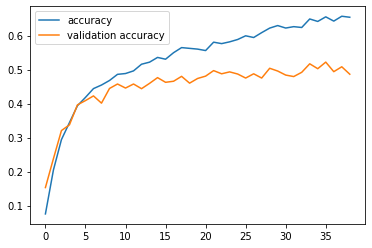

In [41]:
plt.plot(vgg16_history_callback.history["acc"])
plt.plot(vgg16_history_callback.history['val_acc'])
plt.legend(['accuracy', 'validation accuracy'])

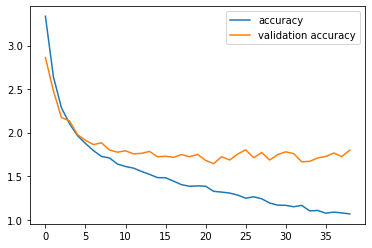

In [42]:
plt.plot(vgg16_history_callback.history["loss"])
plt.plot(vgg16_history_callback.history['val_loss'])
plt.legend(['accuracy', 'validation accuracy'])

In [43]:
score, acc = VGG.evaluate_generator(generator=validation_generator,
                       steps=Step_size_valid)
test_generator.reset()

pred = VGG.predict_generator(generator=test_generator,
                             steps=Step_size_test,
                             verbose=1)
predicted_class_indces = np.argmax(pred, axis=1)

KeyboardInterrupt: 

In [ ]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indces]

In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})
results.to_csv("results.csv", index=False)

In [ ]:
print("Test score ", score)
print("Test acc", acc)
results